In [311]:
import numpy as np
import matplotlib.pyplot as plt

## Defining Parameters:

The variant number 9 was chosen.

In [312]:
#Defining Parameters:

youngs_modulus = 200e3#e9 #PA
poisson_ratio = 0.30
sigmaY = 400#e6 #Pa
r_in = 20#e-6 #m
r_out = 100#e-6 #m
epsilon_v = 0.02
final_time = 1 #seconds
#delta_t = 0.1 #seconds
#time_steps = 10
number_of_elements = 10
number_of_nodes = number_of_elements + 1


## Derived parameters:

In [313]:
#Derived parameters:

lamda = (poisson_ratio * youngs_modulus)/((1 - 2*poisson_ratio)*(1+poisson_ratio))
mu  = youngs_modulus/ (2*(1+poisson_ratio))
epsilon_v_init = (1+poisson_ratio)*(sigmaY/youngs_modulus)

## Initializing all the measurable quantities:

In [314]:
#time intervals
number_of_timesteps = 1000

all_times = np.linspace(0 , 1 , number_of_timesteps)

#Initializing all the measurable quantities:

u = np.zeros((len(all_times),number_of_nodes,1)) #Displacements at every node and every time-step

epsilon_plastic = np.zeros((len(all_times),3,number_of_elements))  #Epsilon_Plastic for every element and in each timestep

epsilon_3D = np.zeros((len(all_times),3,number_of_elements)) # Strain in Voigt Notation for the given problem is 3x1 Matrix

stress_3D = np.zeros((len(all_times),3,number_of_elements)) # Stress in Voigt Noation for the given problem is 3x1 Matrix

Material_Stiffness = np.zeros((3,3)) #Stress = Stiffness x Strain --> C = 3x3 Matrix

Kt = np.zeros((number_of_nodes,number_of_nodes))

F_int = np.zeros((number_of_nodes,1))

#F_ext = np.zeros((number_of_nodes,1))

delta_u = np.zeros((number_of_nodes,1))


## Define Material Routine :

In [315]:
def material_routine(epsilon, epsilon_plastic_old, lamda, mu , sigmaY, youngs_modulus,f):

    C_ijkl = np.array([(2*mu + lamda), lamda, lamda,lamda,(2*mu + lamda), lamda, lamda,lamda,(2*mu + lamda)]).reshape(3,3)
    epsilon_elastic = epsilon - epsilon_plastic_old
    sigma_trial = np.dot(C_ijkl,epsilon_elastic)   #3x1 Matrix
    print("-----------Sigma Trial ===\n",sigma_trial, file =f )
    sigma_trial_dev = sigma_trial - np.sum(sigma_trial)/3          #3x1 Matrix
    
    sigma_trial_eq = np.asscalar(np.sqrt((1.5*np.dot((np.transpose(sigma_trial_dev)),sigma_trial_dev)))) #Scalar
    print("sigma_trial_eq : ", sigma_trial_eq, file =f)
    C_t = np.zeros((3,3))   # Algorithmically Consistent Tangent Stiffness Matrix
    
    if (np.sum(epsilon)<epsilon_v_init):
        print("******************ELASTIC REGION*********************", file=f)
    else:
        print("******************PLASTIC REGION*********************", file = f)

    #Yield Condition ------> Check for Elastic and Plastic Case 
    
    if (sigma_trial_eq - sigmaY) < 0:
        print("(sigma_trial_eq - sigmaY) < 0 -----------------------------------This is in Elastic Region", file=f)
        
        plastic_multiplier = 0
        
        C_t = np.array([(2*mu + lamda), lamda, lamda,lamda,(2*mu + lamda), lamda, lamda,lamda,(2*mu + lamda)]).reshape(3,3)
        
        sigma_new = sigma_trial #2*mu*(epsilon - epsilon_plastic_old) + lamda*np.sum(epsilon - epsilon_plastic_old)
        
        epsilon_plastic_new = epsilon_plastic_old
        
    else :
        print("(sigma_trial_eq - sigmaY) >0 --------------------------------------This is in  Plastic Region", file=f)
        
        plastic_multiplier = sigma_trial_eq /(3*mu + sigmaY)

        sigma_new = np.sum(sigma_trial)/3 + ((sigma_trial_eq - 3*mu*plastic_multiplier)/sigma_trial_eq)*sigma_trial_dev

    
        C_t[0][0] = ((3*lamda + 2*mu)/3 + (4*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[0,0]*sigma_trial_dev[0,0])/sigma_trial_eq**2
        C_t[1][1] = ((3*lamda + 2*mu)/3 + (4*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[1,0]*sigma_trial_dev[1,0])/sigma_trial_eq**2
        C_t[2][2] = ((3*lamda + 2*mu)/3 + (4*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[2,0]*sigma_trial_dev[2,0])/sigma_trial_eq**2
        C_t[0][1] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[0,0]*sigma_trial_dev[1,0])/sigma_trial_eq**2
        C_t[0][2] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[0,0]*sigma_trial_dev[2,0])/sigma_trial_eq**2
        C_t[1][0] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[1,0]*sigma_trial_dev[0,0])/sigma_trial_eq**2
        C_t[1][2] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[1,0]*sigma_trial_dev[2,0])/sigma_trial_eq**2
        C_t[2][0] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[2,0]*sigma_trial_dev[0,0])/sigma_trial_eq**2
        C_t[2][1] = ((3*lamda + 2*mu)/3 - (2*mu*(sigma_trial_eq - 3*mu*plastic_multiplier)/(3*sigma_trial_eq))) - (3*mu*sigma_trial_dev[2,0]*sigma_trial_dev[1,0])/sigma_trial_eq**2
        
        epsilon_plastic_new = epsilon_plastic_old + plastic_multiplier*np.sign(sigma_new)
    print("Ct = \n", C_t, file=f)
    print("Sigma New = \n", sigma_new, file=f)
    print("Epsilon Plastic = \n", epsilon_plastic_new, file=f)
    return sigma_new, C_t, epsilon_plastic_new


## Define Element Routine:

In [316]:
#Defining my Element Routine:

def elementroutine(r,lamda, mu,u_element, epsilon_plastic,sigmaY,youngs_modulus,f):
    length_of_element = r[1]-r[0]
    jacobian = length_of_element/2
    weight = 2
    gauss_point = 0
    N1 = (1-gauss_point)/2
    N2 = (1+gauss_point)/2
    
    B = np.array([-1/(2*jacobian), 1/(2*jacobian), N1/(N1*r[0] + N2*r[1]), N2/(N1*r[0] + N2*r[1]), N1/(N1*r[0] + N2*r[1]), N2/(N1*r[0] + N2*r[1])]).reshape(3,2)
    
    epsilon = np.dot(B, u_element)
    print("Total Strain = \n", epsilon, file=f)
    stress_new , Material_Stiffness1, strain_plastic = material_routine(epsilon, epsilon_plastic, lamda, mu,sigmaY,youngs_modulus,f)
    
    Kt_element = weight * ((B.transpose()).dot(Material_Stiffness1).dot(B)) * (N1*r[0] + N2*r[1])**2 * jacobian
    print(" Kt_element for element = \n", Kt_element, file =f)
    F_int = Kt_element.dot(u_element) 
    print(" F_int for element = \n", F_int, file =f)
    #F_ext = (N1*r[0] + N2*r[1])*stress_new[0]*(np.array([ N1,N2]).reshape(2,1))
    return Kt_element, F_int, stress_new, strain_plastic

## Discretizaton :

In [317]:
#Defining the elements:
r = np.zeros((number_of_elements,2)) 

#ratio of element sizes at outer and inner radius
meshrefinementfactor = 5

#ratio between element sizes of subsequent elements for a geometric series
q = meshrefinementfactor**(1./(number_of_elements-1))

#size of first element
element_1 =(r_out-r_in)*(1-q)/(1-meshrefinementfactor*q)

temp_r = r_in

for i in range(number_of_elements):
    r[i,0] = temp_r
    r[i,1] = temp_r + element_1
    temp_r = r[i,1]
    element_1 = element_1*q

## Assignment/ Assembling Matrix:

In [318]:
#Assembling Matrix
def assembling(number_of_nodes,num):
    A=np.zeros((2,number_of_nodes))
    A[0][num]=1
    A[1][num+1]=1
    return A

## Printing the Displacements into a Text File:

In [319]:
f = open("Output_06_Jul_317.txt", "a")

f.truncate(0)

plastic_reached = 0

In [320]:
for i , time_step in enumerate(all_times):
    print("----------------------ENTERED TIME STEP = ", time_step, "& ITERATION =", i, "----------------", file=f)
    u_time_step = u[i-1,:,:]                                      # PREVIOUS DISPLACEMENT
    print("U at Beginning of time step = ",time_step,"\n", u_time_step, file=f)
    epsilon_plastic_history_time = epsilon_plastic[i-1,:,:]       # PREVIOUS PLASTIC STRAIN
    u_time_step[0,0] = time_step*epsilon_v*r_in/3                 # Ui at the First INNER Node
    epsilon_plastic_temp_storage = np.zeros_like(epsilon_plastic_history_time)
    stress_temp_storage = np.zeros_like(epsilon_plastic_history_time)
    
    ################################# NEWTON RAPHSON METHOD ##################################################
    
    for convergence_test in range(5):
        
        #Kt = np.zeros((number_of_nodes,number_of_nodes)) #initializing within every for-loop 
        
        #G = np.zeros((number_of_nodes,1)) #Initializing F_int for every convergence test
        
        print("---------------------CONVERGENCE TEST NUMBER : ",convergence_test,"--------------------", file= f )  
        if convergence_test >0 :
            
            if np.amax(np.absolute(reduced_delta_u)) <= 0.005*(np.amax(np.absolute(u_time_step[1:,0]))) :
                
                print("\n !!!!!!!!!  Newton Raphson converged at Iteration number : ", convergence_test, " !!!!!!!!!!! \n", file = f)
                
                break
        Kt = np.zeros((number_of_nodes,number_of_nodes))
        
        F_int = np.zeros((number_of_nodes,1))
        
        #G = np.zeros((number_of_nodes,1))
        
        for j in range(number_of_elements):
            print("---------------ELEMENT NO. :", j,"--------------------", file=f)
            A = assembling(number_of_nodes,j)    #Assignment Matrix
            
            u_element = np.dot(A,u_time_step)    #U_Element
            print("u_element=\n", u_element, file=f)
            print("(epsilon_plastic_history_time[:,j]).reshape((3,1)) \n", (epsilon_plastic_history_time[:,j]).reshape((3,1)),file=f)
            Kt_ele, F_int_ele, stress3D2, strain_plastic1 = elementroutine(r[j],lamda, mu,u_element,(epsilon_plastic_history_time[:,j]).reshape((3,1)),sigmaY,youngs_modulus, f)
            
            epsilon_plastic_temp_storage[:,j] = strain_plastic1.transpose()   #Storing the Plastic History Element Wise
            
            stress_temp_storage[:,j] = stress3D2.transpose()
            
            Kt=Kt + ((A.transpose()).dot(Kt_ele).dot(A))                      # Global Stiffness Matrix
            
            F_int=F_int+((A.transpose()).dot(F_int_ele))                      # Global Internal Force
        
        ############################ Calculation of Displacements (K * delta_U = -G) #############################
        
        reduced_Kt = Kt[1:,1:]
        
        reduced_G = F_int[1:,0]
        
        reduced_delta_u = np.linalg.inv(reduced_Kt).dot(-reduced_G)
        
        print("The reduced Delta U at convergence_step :", convergence_test, ": \n",reduced_delta_u, file = f )
        
        u_time_step[1:,0] = u_time_step[1:,0] + reduced_delta_u
        print("U for at convergence_step ", convergence_test,"\n", u_time_step[1:,0], file=f)
    #################################### Updating the Current Displacements and Strains ########################
    
    u[i,:,:] = u_time_step
    
    epsilon_plastic[i,:,:] = epsilon_plastic_temp_storage
    
    stress_3D[i,:,:] = stress_temp_storage
    
    if np.count_nonzero(epsilon_plastic[i,:,:]) !=0 :
        
        plastic_reached += 1
        
        if plastic_reached ==1:
            print("**********************The Material has reached its Plastic Regime at iteration =", i, " ***************", file=f)
            print("epsilon_plastic = \n",epsilon_plastic[i,:,:], file = f)
            index = i-1
    print("U for at the end of time step = ",time_step,"\n", u[i,:,:], file=f)
    print("epsilon_plastic at the end of time step = ",time_step,"\n", epsilon_plastic[i,:,:], file = f)
        
f.close()
        
        
    

## Analytical Solution for Displacements in elastic case: 

In [339]:
r_check = np.unique(r)

u_r_elastic = r_in**3 * epsilon_v*all_times[index-1]/(3*np.square(r_check))

sigma_rr_elastic = -2*youngs_modulus*epsilon_v*all_times[index-1]*r_in**3 / (3*(1+poisson_ratio)*r_check**3)



## Plotting the Numerical v/s Analytical Displacements in Elastic Case:

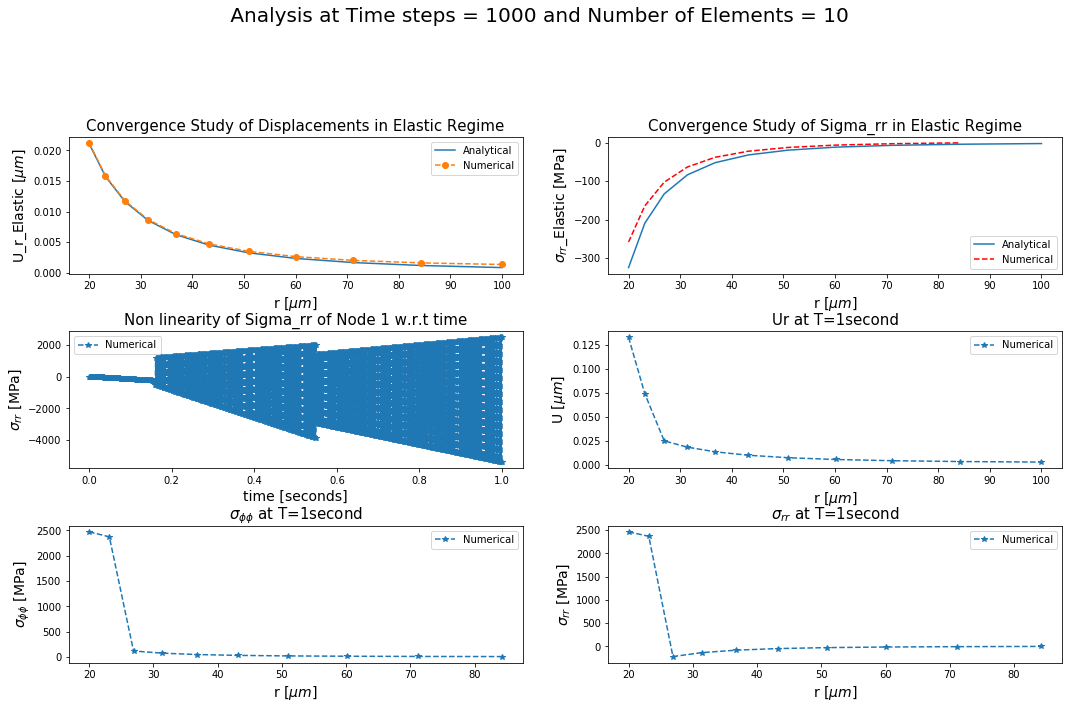

In [340]:
fig, ax = plt.subplots(nrows = 3, ncols=2 ,figsize=((15,10)))
fig.suptitle(" Analysis at Time steps = 1000 and Number of Elements = 10", fontsize=20)
 
ax[0,0].set_title('Convergence Study of Displacements in Elastic Regime', fontsize=15)
ax[0,0].plot(r_check,u_r_elastic, label = 'Analytical')
ax[0,0].plot(r_check,u[index-1,:,0] ,"o--", label ="Numerical")
ax[0,0].set_xlabel('r [$\mu m$]', fontsize=14)
ax[0,0].set_ylabel('U_r_Elastic [$\mu m$]', fontsize=14)
ax[0,0].legend()

ax[0,1].set_title('Convergence Study of Sigma_rr in Elastic Regime', fontsize=15)
ax[0,1].plot(r_check,sigma_rr_elastic, label = 'Analytical')
ax[0,1].plot(r_check[:-1],stress_3D[index-1,0,:] , "r--", label ="Numerical")
ax[0,1].set_xlabel('r [$\mu m$]', fontsize=14)
ax[0,1].set_ylabel('$\sigma_{rr}$_Elastic [MPa]', fontsize=14)
ax[0,1].legend()

ax[1,0].set_title('Non linearity of Sigma_rr of Node 1 w.r.t time', fontsize=15)
ax[1,0].plot(all_times,stress_3D[:,0,0] , '*--',label ="Numerical")
ax[1,0].set_xlabel('time [seconds]', fontsize=14)
ax[1,0].set_ylabel('$\sigma_{rr}$ [MPa]', fontsize=14)
ax[1,0].legend()

ax[2,1].set_title('$\sigma_{rr}$ at T=1second', fontsize=15)
ax[2,1].plot(r_check[:-1],stress_3D[-1,0,:] , '*--',label ="Numerical")
ax[2,1].set_xlabel('r [$\mu m$]', fontsize=14)
ax[2,1].set_ylabel('$\sigma_{rr}$ [MPa]', fontsize=14)
ax[2,1].legend()

ax[2,0].set_title('$\sigma_{\phi \phi}$ at T=1second', fontsize=15)
ax[2,0].plot(r_check[:-1],stress_3D[-1,1,:] , '*--',label ="Numerical")
ax[2,0].set_xlabel('r [$\mu m$]', fontsize=14)
ax[2,0].set_ylabel('$\sigma_{\phi \phi}$ [MPa]', fontsize=14)
ax[2,0].legend()

ax[1,1].set_title('Ur at T=1second', fontsize=15)
ax[1,1].plot(r_check,u[-1,:,0] , '*--',label ="Numerical")
ax[1,1].set_xlabel('r [$\mu m$]', fontsize=14)
ax[1,1].set_ylabel('U [$\mu m$]', fontsize=14)
ax[1,1].legend()

fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig("Plots_at1000timesteps10elements.png")
plt.show()